# Tutorial: intrinsic distribution

In this tutorial you will learn:

 - How to find a intrinsic distribution from data with asymmetric error bars and upper limits
 - How to use UltraNest
 - How to test whether there are two sub-populations

Lets say we want to find the intrinsic velocity dispersion given some noisy data points.

Our data are velocity measurements of a few globular cluster velocities in a dwarf galaxy.

In [1]:
import numpy as np
# velocity dispersions of dwarf galaxies by van Dokkum et al., Nature, 555, 629 https://arxiv.org/abs/1803.10237v1

values = np.array([15, 4, 2, 11, 1, -2, -1, -14, -39, -3])
values_lo = np.array([7, 16, 6, 3, 6, 5, 10, 6, 11, 13])
values_hi = np.array([7, 15, 8, 3, 6, 6, 10, 7, 14, 14])

n_data = len(values)


## Visualise the data

Lets plot the data first to see what is going on:

(-50.0, 50.0)

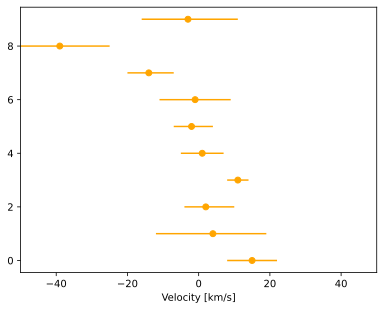

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
xlabel = 'Velocity [km/s]'
plt.xlabel(xlabel)
plt.errorbar(x=values, xerr=[values_lo, values_hi], y=range(n_data), 
             marker='o', ls=' ', color='orange')
plt.xlim(-50, 50);

## Data properties

This scatter plot shows: 

* large, sometimes asymmetric error bars
* intrinsic scatter

### Resampling the data

We could also represent each data point by a cloud of samples.
Each point represents a possible true solution of that galaxy.


Text(0.5, 0, 'Velocity [km/s]')

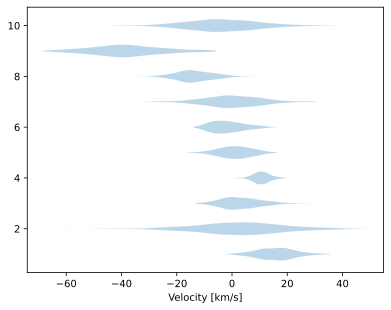

In [3]:
samples = []

for i in range(n_data):
    # draw normal random points
    u = np.random.normal(size=400)
    v = values[i] + np.where(u < 0, u * values_lo[i], u * values_hi[i])
    
    samples.append(v)

samples = np.array(samples)
    
plt.figure()
# for each galaxy, plot alittle cloud with its own colors
plt.violinplot(samples.transpose(), vert=False, showextrema=False)

plt.xlabel(xlabel);


## Model

Lets fit a intrinsic, gaussian distribution.

$$ y \sim \mathrm{Normal}(\mu, \sigma) $$

The model has two unknown parameters:

* the mean $\mu$
* the scatter $\sigma$

Lets write down prior ranges for these parameters:


In [4]:
parameters = ['mean', 'scatter']

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales
    
    params = cube.copy()
    # let slope go from -3 to +3
    lo = -100
    hi = +100
    params[0] = cube[0] * (hi - lo) + lo
    # let scatter go from 1 to 1000
    lo = np.log10(1)
    hi = np.log10(1000)
    params[1] = 10**(cube[1] * (hi - lo) + lo)
    return params


Define the likelihood, which measures how far the data are from the model predictions.
More precisely, how often the parameters would arise under the given parameters.

In [5]:
import scipy.stats

def log_likelihood(params):
    # unpack the current parameters:
    mean, scatter = params

    # compute the probability of each sample
    probs_samples = scipy.stats.norm(mean, scatter).pdf(samples)
    # average over each galaxy, because we assume one of the points is the correct one (logical OR)
    probs_objects = probs_samples.mean(axis=1)
    assert len(probs_objects) == n_data
    # multiply over the galaxies, because we assume our model holds true for all objects (logical AND)
    # for numerical stability, we work in log and avoid zeros
    loglike = np.log(probs_objects + 1e-100).sum()
    return loglike


This likelihood evaluates the model for each object at each sample, and averages the model densities. This corresponds to saying: I don't know which of these options is correct, but I assume one of them is, so by using a logical OR, I sum the probabilities.

The objects are then combined by multiplying the per-object probabilities. This corresponds to saying: I know the model has to describe all of these objects, so using a logical AND, I multiply the probabilities. Here we convert to log space, and sum. The small number is added to gracefully handle when a object probability is zero (distant means and small sigma).


## Solving the problem

In [6]:
import ultranest

sampler = ultranest.ReactiveNestedSampler(parameters, log_likelihood, prior_transform)

Lets first try with relatively poor sampling:

In [7]:
result = sampler.run()

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01  


[ultranest] Likelihood function evaluations: 5503


[ultranest]   logZ = -44.52 +- 0.07969


[ultranest] Effective samples strategy satisfied (ESS = 1597.3, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)


[ultranest]   logZ error budget: single: 0.10 bs:0.08 tail:0.01 total:0.08 required:<0.50


[ultranest] done iterating.


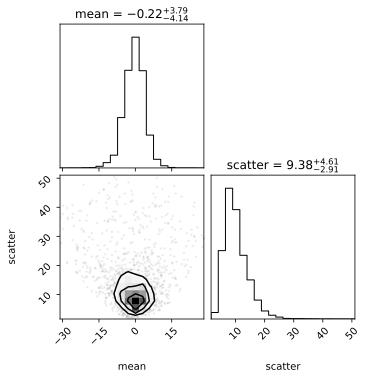

In [8]:
from ultranest.plot import cornerplot
cornerplot(result)

[ultranest] Widening roots to 400 live points (have 400 already) ...


[ultranest] Explored until L=-4e+01  


[ultranest] Likelihood function evaluations: 5503


[ultranest]   logZ = -44.51 +- 0.07414


[ultranest] Effective samples strategy wants to improve: -53.65..-39.64 (ESS = 1597.3, need >4000)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.07 required:<0.50


[ultranest] Widening from 345 to 800 live points before L=-5e+01...


[ultranest] parent value is -inf, so widening roots


[ultranest] Widening roots to 800 live points (have 400 already) ...


[ultranest] Sampling 400 live points from prior ...


[ultranest] Exploring (in particular: L=-inf..-39.64) ...


[ultranest] Explored until L=-4e+01  


[ultranest] Likelihood function evaluations: 13482


[ultranest]   logZ = -44.66 +- 0.06642


[ultranest] Effective samples strategy wants to improve: -51.95..-39.64 (ESS = 3248.9, need >4000)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.16, need <0.5)


[ultranest]   logZ error budget: single: 0.07 bs:0.07 tail:0.00 total:0.07 required:<0.50


[ultranest] Widening from 699 to 1592 live points before L=-5e+01...


[ultranest] parent value is -inf, so widening roots


[ultranest] Widening roots to 1592 live points (have 800 already) ...


[ultranest] Sampling 792 live points from prior ...


[ultranest] Exploring (in particular: L=-inf..-39.64) ...


[ultranest] Explored until L=-4e+01  


[ultranest] Likelihood function evaluations: 26020


[ultranest]   logZ = -44.7 +- 0.03859


[ultranest] Effective samples strategy satisfied (ESS = 6477.3, need >4000)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.03 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)


[ultranest]   logZ error budget: single: 0.05 bs:0.04 tail:0.00 total:0.04 required:<0.50


[ultranest] done iterating.


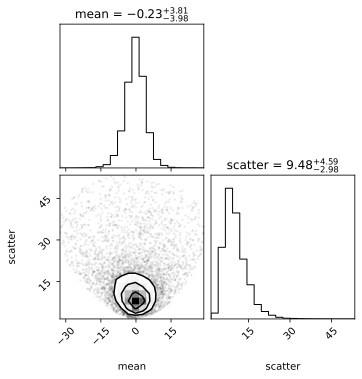

In [9]:
# ask for more samples: increasing the required effective sample size
result = sampler.run(min_ess=4000)
cornerplot(result)

What is the 3 sigma upper limit on the scatter?

In [10]:
mean_samples, scatter_samples = result['samples'].transpose()

# get 3 sigma quantile
quantile = scipy.stats.norm().cdf(3)

# look at the value:
print('scatter is < %.4f km/s at 3 sigma (%.3f%% quantile)' % (scipy.stats.mstats.mquantiles(scatter_samples, quantile), quantile*100))

scatter is < 33.5062 km/s at 3 sigma (99.865% quantile)


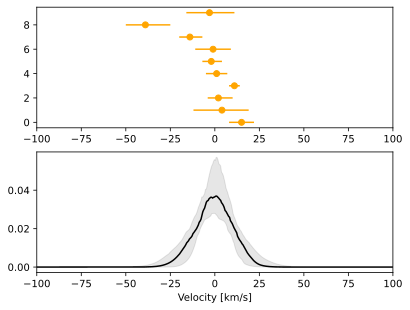

In [11]:
plt.figure()

plt.subplot(2, 1, 1)
plt.errorbar(x=values, xerr=[values_lo, values_hi], y=range(n_data), 
             marker='o', ls=' ', color='orange')
plt.xlim(-100, 100)

plt.subplot(2, 1, 2)
plt.xlim(-100, 100)
plt.xlabel(xlabel)

from ultranest.plot import PredictionBand
x = np.linspace(-100, 100, 400)
band = PredictionBand(x)
bandc = PredictionBand(x)

for params in sampler.results['samples'][:40]:
    mean, scatter = params
    band.add(scipy.stats.norm(mean, scatter).pdf(x))

band.shade(color='k', alpha=0.1)
band.line(color='k');


### Next

1. Try adjusting the number of live points (min_num_live_points) and effective sample size (min_ess) parameters above to decrease the uncertainties.
2. Try different models -- student-t distribution instead of normal, mixture of two gaussians
3. Try varying the prior ranges.
4. Continue with the other tutorials and explore other UltraNest features